# 12 Word World

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Define an Intentionally Limited Vocabulary

We'll train a model with a text that's limited to this vocabulary.

In [3]:
use_verbs = True

adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

if use_verbs:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
        for _ in range(sentence_count)
    ]

if not use_verbs:
    twelve_word_world = [
        random.choice(adjectives) + " " + random.choice(nouns)
        for _ in range(sentence_count)
    ]

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return " <|endoftext|> ".join(strings) + " <|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'endless river shines <|endoftext|> endless mountain flows <|endoftext|> serene mountain grows <|endoftext|> vibrant river shines <|endoftext|> silent dream whispers <|endoftext|> silent mountain grows <|endoftext|> serene idea whispers <|endoftext|> endless mountain grows <|endoftext|> vibrant dream grows <|endoftext|> silent dream whispers <|endoftext|> silent river whispers <|endoftext|> silent mountain shines <|endoftext|> endless mountain whispers <|endoftext|> vibrant mountain grows <|endoftext|> endless dream shines <|endoftext|> vibrant mountain whispers <|endoftext|> serene idea grows <|endoftext|> endless river whispers <|endoftext|> vibrant idea grows <|endoftext|> silent mountain flows <|endoftext|> silent idea flows <|endoftext|> silent river flows <|endoftext|> serene idea shines <|endoftext|> serene mountain flows <|endoftext|> endless idea whispers <|endoftext|> serene idea whispers <|endoftext|> silent dream whispers <|endoftext|> endless idea whispers <|endoftext|> si

In [6]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(text_data)
tokenizer = SimpleTokenizer(source)

print("Vocabulary size", len(tokenizer.str_to_int))
print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Vocabulary size 14
Sentences 100
Total characters 3539
Total tokens 400


This is our entire vocabulary, including special tokens.

In [7]:
tokenizer.int_to_str

{0: '<|endoftext|>',
 1: '<|unk|>',
 2: 'dream',
 3: 'endless',
 4: 'flows',
 5: 'grows',
 6: 'idea',
 7: 'mountain',
 8: 'river',
 9: 'serene',
 10: 'shines',
 11: 'silent',
 12: 'vibrant',
 13: 'whispers'}

As the sentences have different length depening on whether we enabled, or not, the use of verbs, we need to calculate the context length.

In [8]:
context_length = len(tokenizer.text_to_tokens(twelve_word_world[0] + " <|endoftext|>").squeeze())

context_length

4

## Create a Tiny GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [9]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = len(tokenizer.str_to_int),
    context_length = context_length,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

model.eval()

GptModel(
  (token_embeddings): Embedding(14, 3)
  (positional_embeddings): Embedding(4, 3)
  (dropout_embeddings): Dropout(p=0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=3, out_features=3, bias=False)
        (W_key): Linear(in_features=3, out_features=3, bias=False)
        (W_value): Linear(in_features=3, out_features=3, bias=False)
        (out_proj): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=3, out_features=12, bias=True)
          (1): Gelu()
          (2): Linear(in_features=12, out_features=3, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0, inplace=False)
    )
  )
  (final_normal

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

240

### Store the Initial Embedding State

Now that our model has just been created with random weights, we'll store its embedding weights so that we can later compare the initial values with the trained ones.

In [11]:
initial_embeddings = model.token_embeddings.weight.clone().to("cpu")

## Preparing the Training and Validation Datasets

In [12]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

endless dream shines <|endoftext|> serene dream flows <|endoftext|> serene mountain shines <|endoftext|> serene mountain flows <|endoftext|> vibrant river shines <|endoftext|> silent river grows <|endoftext|> silent mountain shines <|endoftext|> serene river flows <|endoftext|> vibrant mountain whispers <|endoftext|> vibrant dream shines <|endoftext|>


In [13]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [14]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.762065730311654
Validation loss 2.756226968765259


## Training the Model

### Prepare a Trainer

In [15]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Run the Training Loop

In [16]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.711317468773235
- Evaluation loss 2.7386598587036133
- Generated: silent mountain dream mountain mountain

- Step 50
- Train loss 1.4682102108543569
- Evaluation loss 1.5259342193603516
- Generated: silent mountain whispers

- Step 100
- Train loss 1.0956420302391052
- Evaluation loss 1.3002114295959473
- Generated: silent river shines

- Step 150
- Train loss 1.1097963384606622
- Evaluation loss 1.266727900505066
- Generated: silent idea whispers

- Step 200
- Train loss 1.0830378098921343
- Evaluation loss 1.1882644653320313
- Generated: silent river whispers

- Step 250
- Train loss 1.1204474744471637
- Evaluation loss 1.156644630432129
- Generated: silent mountain flows

- Step 300
- Train loss 1.1039558405225927
- Evaluation loss 1.1314115405082703
- Generated: silent dream whispers

- Step 350
- Train loss 1.1259606656703083
- Evaluation loss 1.2350085973739624
- Generated: silent mountain whispers
- Generated: silent idea shines

- Step 400
- Train loss 

In [17]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless mountain whispers'

## Evaluate the Model

### Loss Changes

<Figure size 640x480 with 0 Axes>

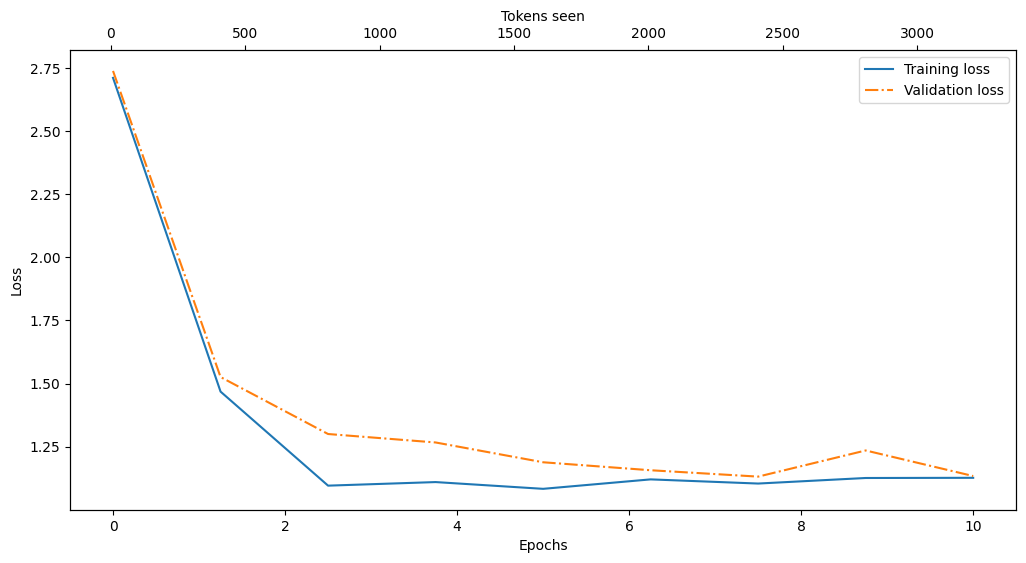

In [18]:
def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    plt.clf()
    fig, ax1 = plt.subplots()

    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    plt.show()

%matplotlib inline

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

### Embedding Changes

In [19]:
trained_embeddings = model.token_embeddings.weight.clone().to("cpu")

In [20]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 1,
 3: 0,
 4: 2,
 5: 2,
 6: 1,
 7: 1,
 8: 1,
 9: 0,
 10: 2,
 11: 0,
 12: 0,
 13: 2}

In [21]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

<Figure size 640x480 with 0 Axes>

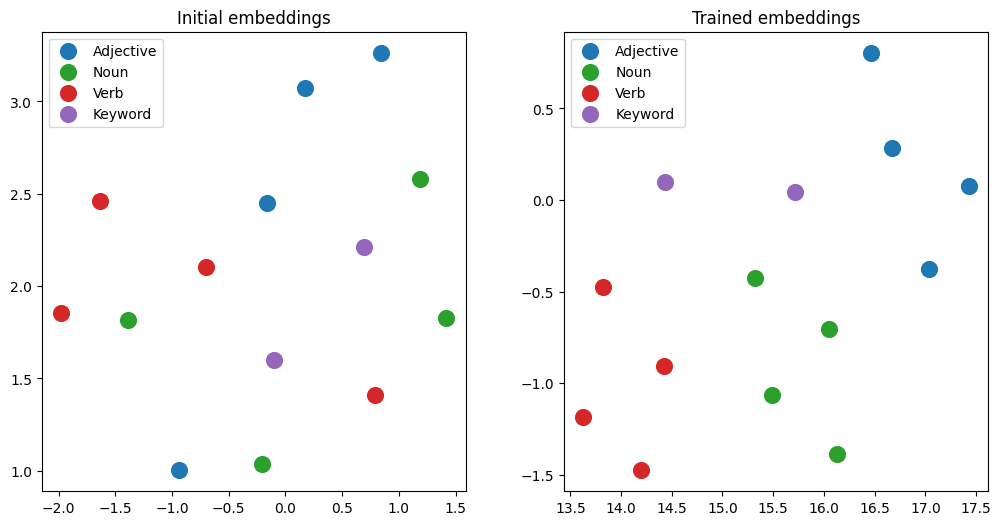

In [22]:
def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        selection = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[selection][:, 0],
            reduced_embeddings[selection][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_umap_embedding_changes():
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

%matplotlib inline

plot_umap_embedding_changes()

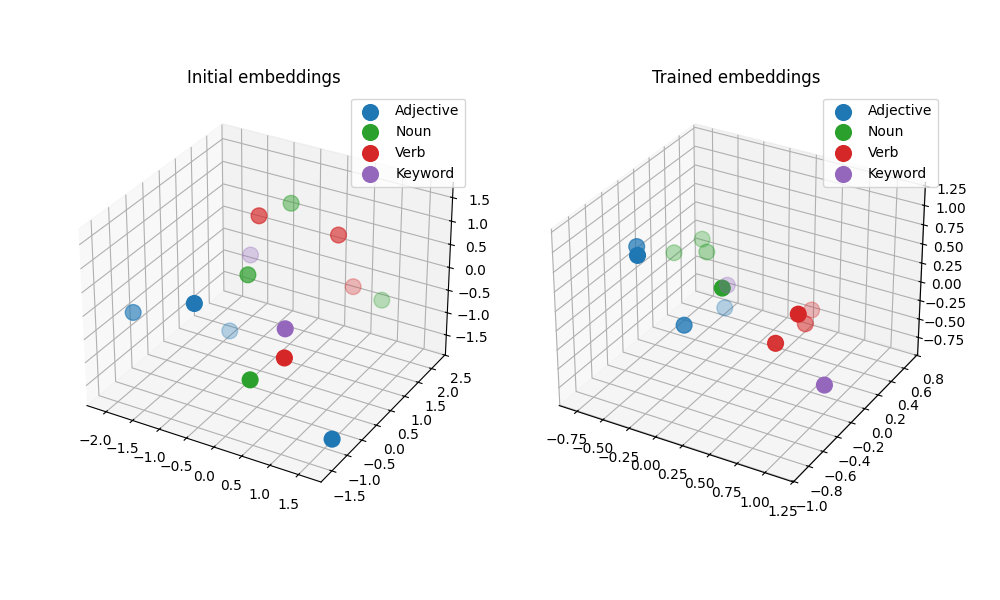

In [23]:
%matplotlib widget

def scat_3d_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            embeddings[index][:, 0].detach().numpy(),
            embeddings[index][:, 1].detach().numpy(),
            embeddings[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_3d_embedding_differences():
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_3d_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_3d_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

if initial_embeddings.shape[1] == 3:
    plot_3d_embedding_differences()